In [3]:
# Data Manipulation and Calculation
import pandas as pd  # for data manipulation and analysis
import numpy as np  # for numerical computations

# Visualization
import matplotlib.pyplot as plt  # for plotting graphs and charts
import seaborn as sns  # for more advanced data visualizations

# PyTorch for Deep Learning
import torch  # for tensor computations and building computation graphs
import torch.nn as nn  # for constructing layers of the neural network
from torch.utils.data import TensorDataset, RandomSampler, DataLoader  # for creating an iterable over the dataset

# Transformers for Albert Model
from transformers import AdamW  # the optimizer used for training the model
from transformers import AlbertTokenizer  # for tokenizing the text data
from transformers import AlbertForSequenceClassification  # for sequence classification tasks
from transformers import get_linear_schedule_with_warmup  # for adjusting the learning rate over training epochs

# Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## Loading ALBERT Tokenizer and Model 
This cell initializes the ALBERT tokenizer and the ALBERT model, which is configured for a binary classification task.

In [4]:
# Load the ALBERT tokenizer.
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

# Load AlbertForSequenceClassification
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", 
    num_labels = 2, # The number of output labels for binary classification
    output_attentions = False, 
    output_hidden_states = False,
)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Loading and Splitting
This cell loads the dataset into a pandas dataframe and randomly splits it into training and testing subsets, with the training subset comprising 80% of the total data. It then prints the number of sentences and a sample for each dataframe.

In [6]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('train.tsv', sep='\t')

# Report the number of sentences
print('Total number of sentences: {:,}\n'.format(df.shape[0]))

# Randomly split the data into training and testing dataframes
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Print number of training sentences and a sample of the train_df
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print(train_df.sample(10))

# Print number of testing sentences and a sample of the test_df
print('Number of testing sentences: {:,}\n'.format(test_df.shape[0]))
print(test_df.sample(10))

Total number of sentences: 156,060

Number of training sentences: 124,848

        PhraseId  SentenceId  \
85590      85591        4426   
124166    124167        6666   
115830    115831        6171   
74580      74581        3824   
76655      76656        3941   
109916    109917        5822   
80322      80323        4138   
151557    151558        8267   
50146      50147        2463   
28703      28704        1329   

                                                   Phrase  Sentiment  
85590   do n't seem to have much emotional impact on t...          1  
124166                                It 's a good film ,          3  
115830                                            possess          2  
74580                                    a college comedy          2  
76655            did n't Hollywood think of this sooner ?          2  
109916                                          moodiness          1  
80322        another cartoon with an unstoppable superman          2  
1515

## Data Preprocessing
This cell defines a function to convert the sentiment labels into binary form, discards neutral sentiments, and prepares the training and testing data with these converted labels.

In [7]:
# Function to prepare data: Convert sentiments to binary form and remove neutral sentiments
def prepare_data(df):
    df = df.copy()  # Explicitly create a copy of the dataframe
    df['binary_sentiment'] = df.Sentiment.apply(lambda x: 0 if x < 2 else 1 if x > 2 else 'neutral')
    df = df[df.binary_sentiment != 'neutral']
    df['binary_sentiment'] = df['binary_sentiment'].fillna(0).astype(int)
    sentences = df.Phrase.values
    labels = df.binary_sentiment.values
    labels = torch.tensor(labels)
    return sentences, labels

# Prepare the training and testing data
train_sentences, train_labels = prepare_data(train_df)
test_sentences, test_labels = prepare_data(test_df)

## Phrase Tokenization and Visualization
This cell tokenizes all phrases in the training and testing data, calculates the number of tokens in each phrase, and visualizes the distribution of token counts with a histogram.

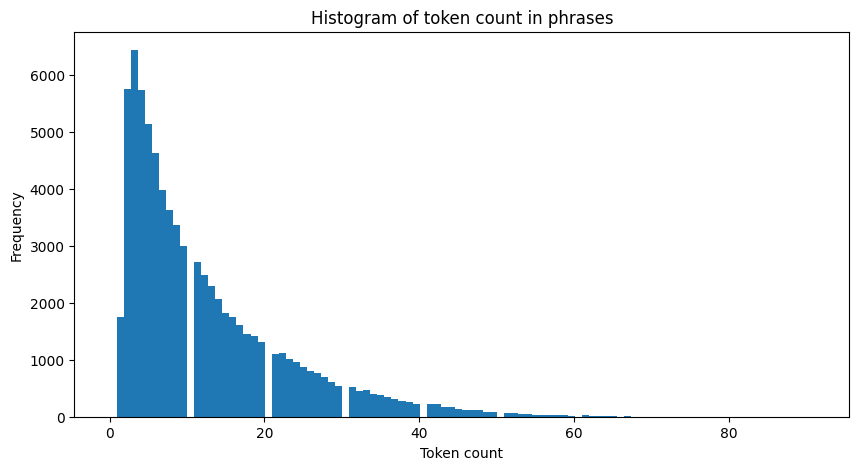

In [6]:
# Tokenize all of the phrases and count the number of tokens
token_lens_train = [len(tokenizer.tokenize(sent)) for sent in train_sentences]
token_lens_test = [len(tokenizer.tokenize(sent)) for sent in test_sentences]

# Combine the token lengths of both datasets
token_lens = token_lens_train + token_lens_test

# Plot the distribution of token counts
plt.figure(figsize=(10, 5))
plt.hist(token_lens, bins=100)
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Histogram of token count in phrases')
plt.show()

## Sequence Encoding 
This cell encodes the phrases from the training and testing data into a format suitable for the ALBERT model, including the conversion of labels into long tensor type, tokenization, padding, and attention mask creation.

In [7]:
def encode_sequences(sentences):
    # Tokenize and encode sequences
    encoded_batch = tokenizer(sentences.tolist(),                      
                              add_special_tokens = True,
                              max_length = 65,  # Changed based on your data analysis
                              padding='max_length',
                              truncation=True,
                              return_attention_mask = True,
                              return_tensors = 'pt')
    # Access values from the encoded_batch
    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']
    return input_ids, attention_masks

# Convert labels to long tensor type
train_labels = train_labels.long()
test_labels = test_labels.long()

# Encode sequences for the training and testing sets
train_input_ids, train_attention_masks = encode_sequences(train_sentences)
test_input_ids, test_attention_masks = encode_sequences(test_sentences)

## DataLoader Creation
This cell creates DataLoaders for the training and testing data, which will allow the model to efficiently load the data in batches during training and testing.

In [8]:
# Define a batch size
batch_size = 12

# Function to create dataloader
def create_dataloader(input_ids, attention_masks, labels, batch_size):
    # Create a TensorDataset instance
    data = TensorDataset(input_ids, attention_masks, labels)

    # Create a RandomSampler to sample data randomly
    sampler = RandomSampler(data)

    # Create a DataLoader
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    
    return dataloader

# Create DataLoaders for training and testing sets
train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_labels, batch_size)
test_dataloader = create_dataloader(test_input_ids, test_attention_masks, test_labels, batch_size)

## Device Selection
This cell checks whether a GPU is available, and if so, assigns the ALBERT model to run on the GPU for faster computations; if a GPU isn't available, it defaults to using the CPU.

In [9]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Move the model to the device
model = model.to(device)

No GPU available, using the CPU instead.


## Optimizer and Learning Rate Scheduler Setup
This cell sets up the AdamW optimizer with a specific learning rate and epsilon, defines the number of training epochs, calculates the total number of training steps, and creates a learning rate scheduler which gradually decreases the learning rate across epochs.

In [10]:
# Set optimizer, epochs, steps
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training and Validation Loops
Overview of Steps:

1. **Utility Function**: Define a helper function `flat_accuracy` to calculate the accuracy of our model's predictions.

2. **Metric Initialization**: Initialize lists to store the training loss, accuracy, precision, recall, and F1 score for each epoch.

3. **Training Loop**: For each epoch:
   - Print the epoch number.
   - Initialize a total loss accumulator and prediction & true label lists.
   - Put our model into training mode.
   - Iterate over each batch of data in the training set:
     - Every 40 batches, we print the progress.
     - Move the batch data to the GPU (if available).
     - Zero the gradients computed from the previous step.
     - Pass the batch data through the model, getting a loss and outputs.
     - Accumulate the loss.
     - Perform a backward pass to compute gradients.
     - Clip gradients to prevent "exploding gradients".
     - Update the model's parameters using the computed gradients.
     - Compute the batch's accuracy and accumulate it.
     - Store the batch's predictions and true labels.
   - Compute average loss and accuracy for the entire training set.
   - Compute precision, recall, and F1 score for the training set and store these metrics.
   - Print the average loss, accuracy, precision, recall, and F1 score for this epoch.<br><br>

4. **Validation Loop**: Evaluate model on the validation set:
   - Switch the model into evaluation mode.
   - Initialize accumulators for total accuracy and loss.
   - Iterate over each batch in the validation set:
     - Move batch data to the GPU (if available).
     - Pass batch data through the model without computing gradients.
     - Accumulate the batch's loss.
     - Compute and accumulate the batch's accuracy.
   - Compute average accuracy and loss for the entire validation set.
   - Print the validation accuracy and loss.



In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define metric placeholders
train_loss_values = []
train_acc_values = []
train_precision_values = []
train_recall_values = []
train_f1_values = []

# Training loop
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_train_loss = 0
    total_train_acc = 0
    predictions , true_labels = [], []

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()
        scheduler.step()

        # Calculate the accuracy for this batch
        preds = torch.argmax(outputs.logits, dim=1).flatten()
        acc = (preds == b_labels).cpu().numpy().mean() * 100
        total_train_acc += acc

        # Store predictions and true labels for calculating additional metrics
        predictions.append(preds.detach().cpu().numpy())
        true_labels.append(b_labels.detach().cpu().numpy())

    # Calculate the average loss and accuracy over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader) 
    avg_train_acc = total_train_acc / len(train_dataloader) 

    # Flatten outputs for metrics calculation
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    avg_train_precision = precision_score(true_labels, predictions)
    avg_train_recall = recall_score(true_labels, predictions)
    avg_train_f1 = f1_score(true_labels, predictions)

    # Store all metrics for this epoch
    train_loss_values.append(avg_train_loss)
    train_acc_values.append(avg_train_acc)
    train_precision_values.append(avg_train_precision)
    train_recall_values.append(avg_train_recall)
    train_f1_values.append(avg_train_f1)

    print(f"Average training loss: {avg_train_loss:.2f}")
    print(f"Average training accuracy: {avg_train_acc:.2f}")
    print(f"Average training precision: {avg_train_precision:.2f}")
    print(f"Average training recall: {avg_train_recall:.2f}")
    print(f"Average training F1 score: {avg_train_f1:.2f}")

    # Validation
    print("\nRunning Validation...")

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                
        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(test_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

======== Epoch 1 / 2 ========
  Batch    40  of  5,107.
  Batch    80  of  5,107.
  Batch   120  of  5,107.
  Batch   160  of  5,107.
  Batch   200  of  5,107.
  Batch   240  of  5,107.
  Batch   280  of  5,107.
  Batch   320  of  5,107.
  Batch   360  of  5,107.
  Batch   400  of  5,107.
  Batch   440  of  5,107.
  Batch   480  of  5,107.
  Batch   520  of  5,107.
  Batch   560  of  5,107.
  Batch   600  of  5,107.
  Batch   640  of  5,107.
  Batch   680  of  5,107.
  Batch   720  of  5,107.
  Batch   760  of  5,107.
  Batch   800  of  5,107.
  Batch   840  of  5,107.
  Batch   880  of  5,107.
  Batch   920  of  5,107.
  Batch   960  of  5,107.
  Batch 1,000  of  5,107.
  Batch 1,040  of  5,107.
  Batch 1,080  of  5,107.
  Batch 1,120  of  5,107.
  Batch 1,160  of  5,107.
  Batch 1,200  of  5,107.
  Batch 1,240  of  5,107.
  Batch 1,280  of  5,107.
  Batch 1,320  of  5,107.
  Batch 1,360  of  5,107.
  Batch 1,400  of  5,107.
  Batch 1,440  of  5,107.
  Batch 1,480  of  5,107.
  Batch 

## Testing Loop
Overview of Steps:

1. **Setup**: Print a statement to indicate the beginning of the testing phase. Initialize several lists to keep track of the metrics for each batch of data in the testing set.

2. **Loss Function**: Specify loss function (Cross-Entropy Loss).

3. **Testing Loop**: Iterate over each batch in the testing data loader. For each batch:
    - Move batch inputs and labels to the GPU (if available).
    - Ask the model to make predictions on the batch inputs, but without updating the model's parameters (`with torch.no_grad()`). The `outputs` contain the predicted logits.
    - Detach the logits from the computational graph and move them to the CPU, then convert them to a NumPy array. The true labels are also moved to the CPU.
    - Calculate the loss for this batch using the specified loss function, and append this to our list of batch losses.
    - Convert our model's output logits to predicted classes using `argmax`, and flatten this for comparison with the true labels.
    - Compute various metrics (accuracy, precision, recall, F1 score) for this batch, and store these in their respective lists.
    - Extend overall list of predictions and true labels with the batch-level predictions and true labels.<br><br>

4. **Overall Metrics**: Compute overall metrics for the entire test set by comparing all the predictions against all the true labels. 

5. **Summary**: Gather test metrics into a dictionary and convert to pd df for a neat and clear summary to be printed out.



In [46]:
import torch.nn as nn

# Testing loop
print('======== Testing ========')

# Define lists to store per-batch metrics
batch_losses = []
batch_accuracies = []
batch_precisions = []
batch_recalls = []
batch_f1s = []

# Reset the values of predictions and true_labels
predictions, true_labels = [], []

loss_fn = nn.CrossEntropyLoss()

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate loss
    loss = loss_fn(outputs.logits, b_labels)
    batch_losses.append(loss.item())

    # Use argmax to get the predicted labels
    preds = np.argmax(logits, axis=1).flatten()

    # Compute metrics
    batch_accuracy = accuracy_score(label_ids, preds)
    batch_precision = precision_score(label_ids, preds, zero_division=1)
    batch_recall = recall_score(label_ids, preds, zero_division=1)
    batch_f1 = f1_score(label_ids, preds, zero_division=1)

    # Store metrics
    batch_accuracies.append(batch_accuracy)
    batch_precisions.append(batch_precision)
    batch_recalls.append(batch_recall)
    batch_f1s.append(batch_f1)

    # Store predictions and true labels for later evaluation
    predictions.extend(preds)
    true_labels.extend(label_ids)

# Recalculate the metrics for the test set
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions)
test_recall = recall_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions)

# Update the test_summary_data with the recalculated metrics
test_summary_data = {
    'Average Loss': [np.mean(batch_losses)],
    'Accuracy': [test_accuracy],
    'Precision': [test_precision],
    'Recall': [test_recall],
    'F1-Score': [test_f1],
}

# Recreate the DataFrame
test_summary_df = pd.DataFrame(test_summary_data)

print("\nTesting Summary:")
display(test_summary_df)

======== Testing ========

Testing Summary:


,Average Loss,Accuracy,Precision,Recall,F1-Score
0,0.274822,0.937944,0.949111,0.936907,0.942969


## Visualizations & Performance Summary Information

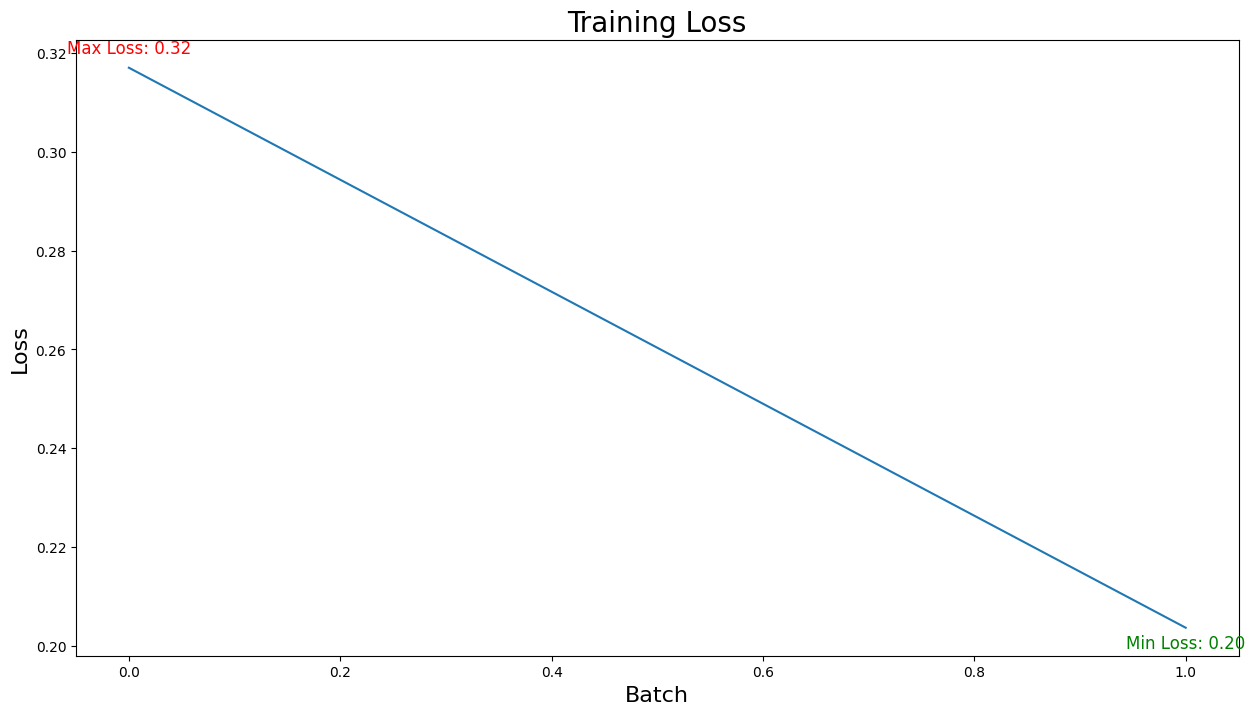

In [34]:
plt.figure(figsize=(15,8))
plt.title("Training Loss", fontsize=20)
plt.xlabel("Batch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.plot(train_loss_values)

# Add callouts for some values
max_loss = max(train_loss_values)
max_loss_batch = train_loss_values.index(max_loss)
plt.annotate(f'Max Loss: {max_loss:.2f}',  # Show only two decimal places
             (max_loss_batch, max_loss),
             textcoords="offset points",
             xytext=(0,10),
             ha='center',
             fontsize=12,
             color='red')

min_loss = min(train_loss_values)
min_loss_batch = train_loss_values.index(min_loss)
plt.annotate(f'Min Loss: {min_loss:.2f}',  # Show only two decimal places
             (min_loss_batch, min_loss),
             textcoords="offset points",
             xytext=(0,-15),  
             ha='center',
             fontsize=12,
             color='green')

plt.show()

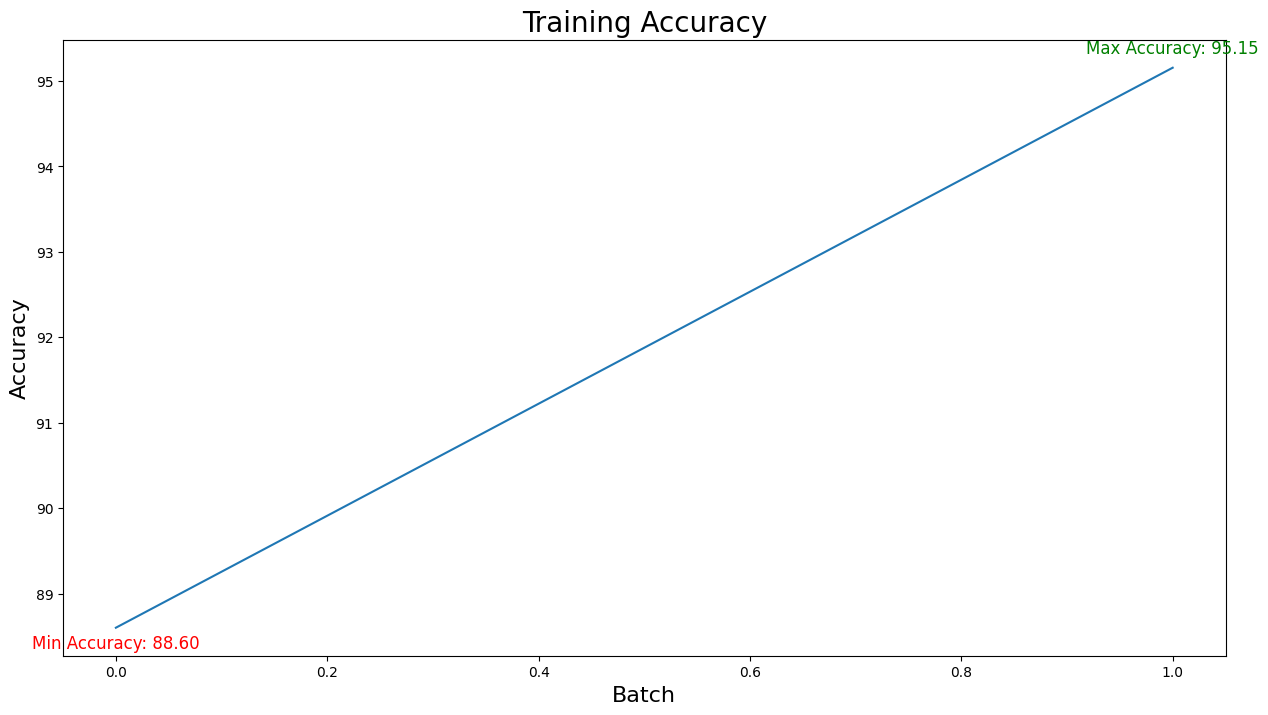

In [35]:
plt.figure(figsize=(15,8))
plt.title("Training Accuracy", fontsize=20)  # Title with Proper Capitalization
plt.xlabel("Batch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.plot(train_acc_values)

# Add callouts for some values
max_acc = max(train_acc_values)
max_acc_batch = train_acc_values.index(max_acc)
plt.annotate(f'Max Accuracy: {max_acc:.2f}',  # Show only two decimal places
             (max_acc_batch, max_acc),
             textcoords="offset points",
             xytext=(0,10),
             ha='center',
             fontsize=12,
             color='green')

min_acc = min(train_acc_values)
min_acc_batch = train_acc_values.index(min_acc)
plt.annotate(f'Min Accuracy: {min_acc:.2f}',  # Show only two decimal places
             (min_acc_batch, min_acc),
             textcoords="offset points",
             xytext=(0,-15),
             ha='center',
             fontsize=12,
             color='red')

plt.show()

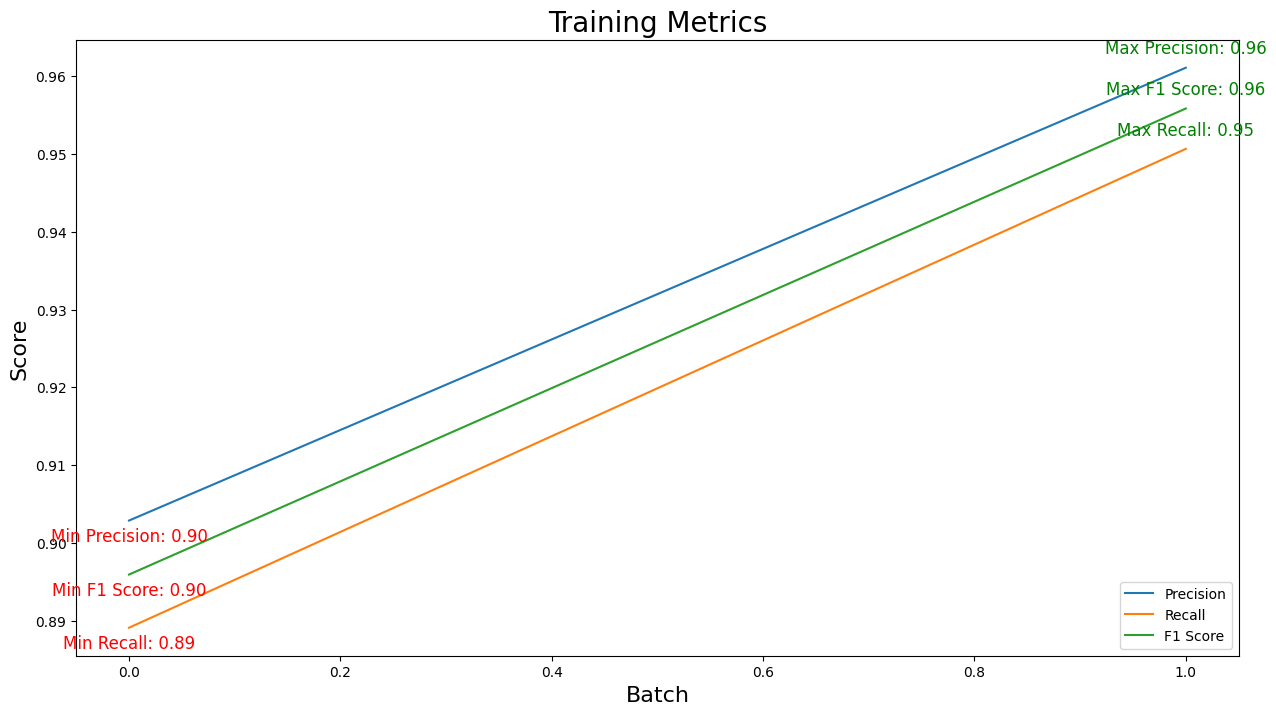

In [38]:
plt.figure(figsize=(15,8))
plt.title("Training Metrics", fontsize=20)
plt.xlabel("Batch", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.plot(train_precision_values, label='Precision')
plt.plot(train_recall_values, label='Recall')
plt.plot(train_f1_values, label='F1 Score')

metrics = [train_precision_values, train_recall_values, train_f1_values]
labels = ['Precision', 'Recall', 'F1 Score']

for metric, label in zip(metrics, labels):
    max_score = max(metric)
    min_score = min(metric)
    max_score_batch = metric.index(max_score)
    min_score_batch = metric.index(min_score)

    plt.annotate(f'Max {label}: {max_score:.2f}',  
                 (max_score_batch, max_score),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=12,
                 color='green')

    plt.annotate(f'Min {label}: {min_score:.2f}',  
                 (min_score_batch, min_score),
                 textcoords="offset points",
                 xytext=(0,-15),
                 ha='center',
                 fontsize=12,
                 color='red')

plt.legend(loc='lower right')
plt.show()

<Axes: >

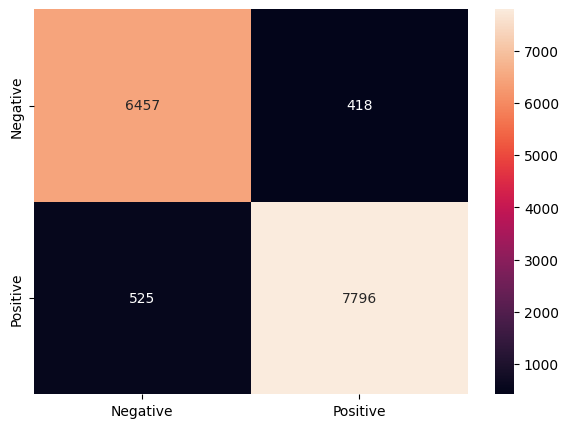

In [23]:
# Get the predictions from the model
model.eval()
predictions , true_labels = [], []
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))
df_cm = pd.DataFrame(cm, index = ["Negative","Positive"], columns = ["Negative","Positive"])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

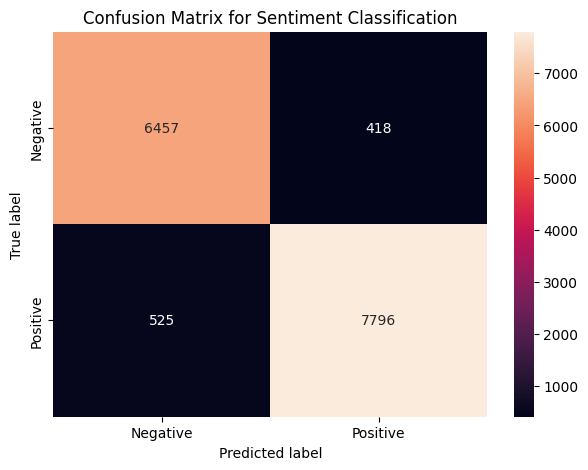

In [24]:
# Update confusion matrix with title, x and y axis labels
cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))
df_cm = pd.DataFrame(cm, index = ["Negative","Positive"], columns = ["Negative","Positive"])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion Matrix for Sentiment Classification')  # title
plt.ylabel('True label')  # y-axis label
plt.xlabel('Predicted label')  # x-axis label
plt.show()

In [31]:
# Convert lists to numpy arrays
true_labels_np = np.array(true_labels)
predictions_np = np.array(predictions)

# Convert to class predictions
predictions_np = predictions_np.argmax(axis=-1)

# Ensure binary data type by rounding predictions to nearest integer (0 or 1)
true_labels_np = true_labels_np.astype(int)  # Ensure labels are also integer type

# Define data for the summary tables
train_summary_data = {
    'Average Loss': [np.mean(train_loss_values)],
    'Average Accuracy': [np.mean(train_acc_values)],
    'Precision': [np.mean(train_precision_values)],
    'Recall': [np.mean(train_recall_values)],
    'F1-Score': [np.mean(train_f1_values)],
}

test_summary_data = {
    'Average Loss': [avg_val_loss],
    'Average Accuracy': [test_accuracy],
    'Precision': [precision_score(true_labels_np, predictions_np)],
    'Recall': [recall_score(true_labels_np, predictions_np)],
    'F1-Score': [f1_score(true_labels_np, predictions_np)],
}

# Create DataFrames
train_summary_df = pd.DataFrame(train_summary_data)
test_summary_df = pd.DataFrame(test_summary_data)

print("Training Summary:")
display(train_summary_df)
print("\nTesting Summary:")
display(test_summary_df)

Training Summary:


,Average Loss,Average Accuracy,Precision,Recall,F1-Score
0,0.260339,91.878957,0.931986,0.919881,0.925892



Testing Summary:


,Average Loss,Average Accuracy,Precision,Recall,F1-Score
0,0.274809,0.937944,0.949111,0.936907,0.942969
